In [88]:
import networkx as nx
import osmnx as ox
import json
import warnings
warnings.filterwarnings('ignore')

OUTPUT_FILE = "output/directions.json"

In [89]:
def get_bbox_bound(waypoints):
    north, south, east, west = -100, 100, -100, 100
    for waypoint in waypoints:
        if waypoint['lat'] > north:
            north = waypoint['lat']
        if waypoint['lat'] < south:
            south = waypoint['lat']
        if waypoint['lng'] > east:
            east = waypoint['lng']
        if waypoint['lng'] < west:
            west = waypoint['lng']
    
    diff = 0.02
    return north+diff, south-diff, east+diff, west-diff

In [90]:
def get_paths(G, waypoints: list, travel_modes: list, wk_color="springgreen"):
    paths = []
    path_colors = []
    for i in range(1, len(waypoints)):
        origin = waypoints[i-1]['lng'], waypoints[i-1]['lat']
        end = waypoints[i]['lng'], waypoints[i]['lat'] # find the nearest node to the start location
        orig_node = ox.nearest_nodes(G, origin[0], origin[1])
        end_node = ox.nearest_nodes(G, end[0], end[1])
        if travel_modes[i][0] == "Walking":
            path_colors.append(wk_color)
        else:
            # path_colors.append(travel_modes[i][1])
            path_colors.append("darkgray")
            G.add_edge(orig_node, end_node)
            
        paths.append(nx.shortest_path(G, orig_node, end_node))
    ox.distance.add_edge_lengths(G)
    return paths, path_colors

In [91]:
def str_geo_value(geo_value):
    return str(round(float(geo_value), 2))

In [92]:
def load_json_list(str):
    output = []
    try:
        output = json.loads(str)
    except json.decoder.JSONDecodeError:
        pass
    
    return output


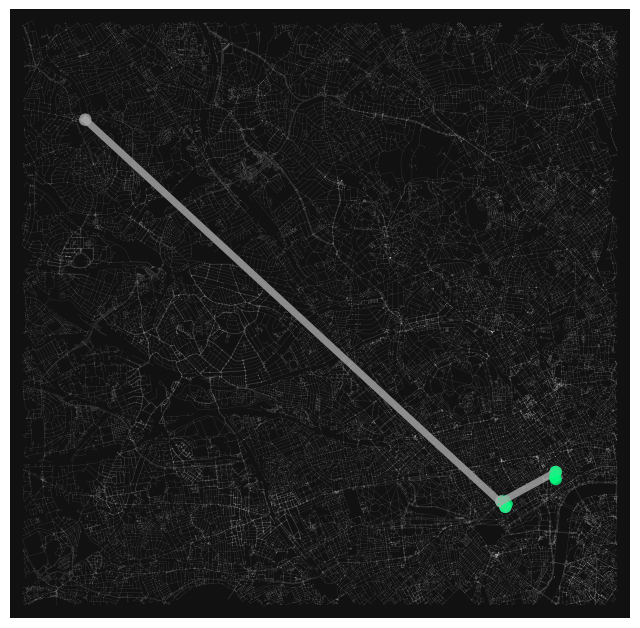

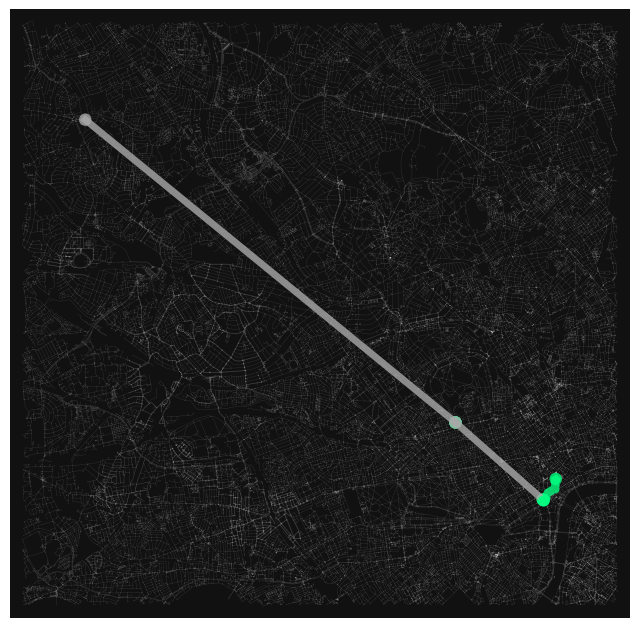

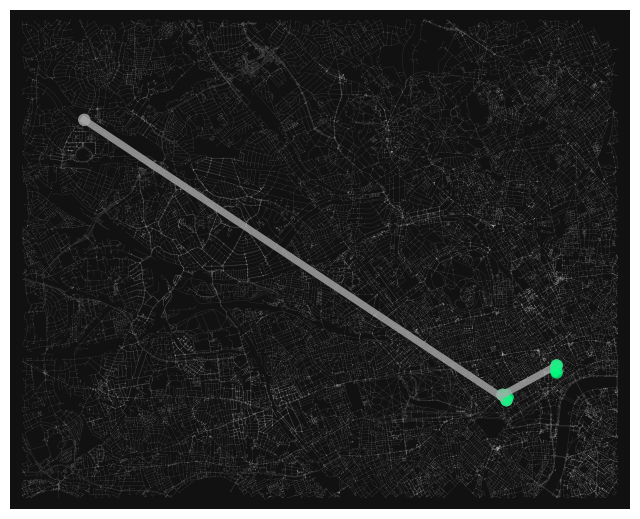

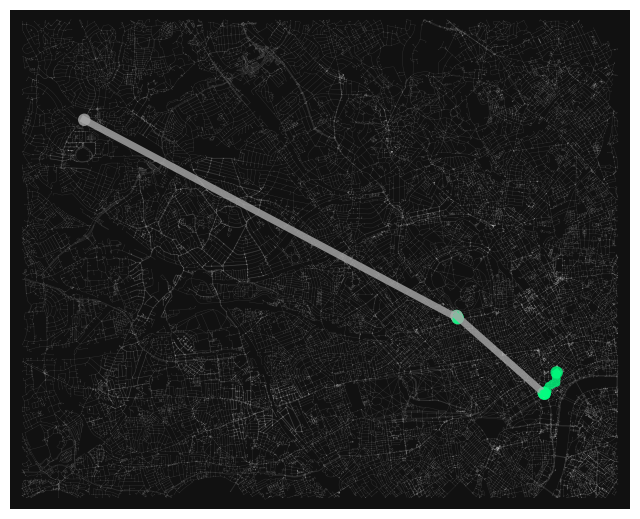

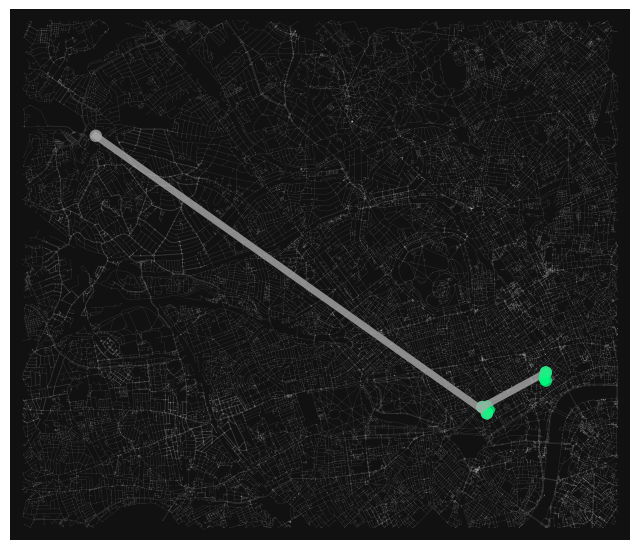

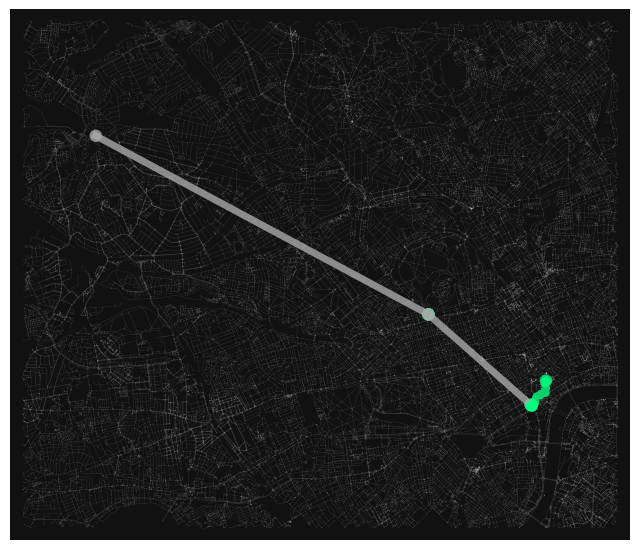

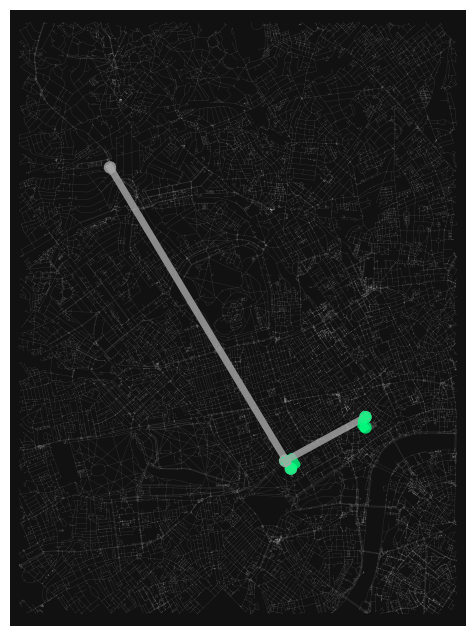

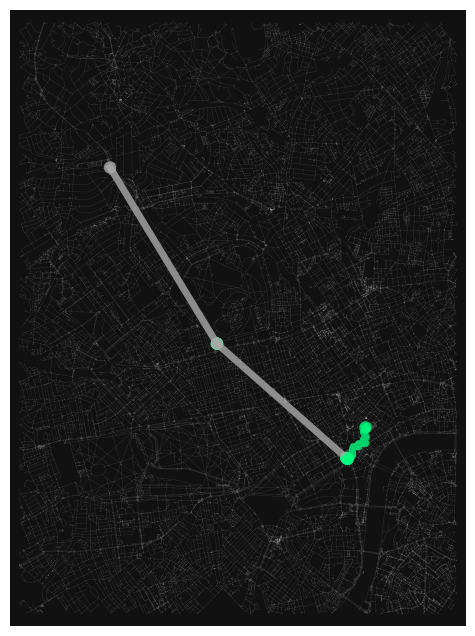

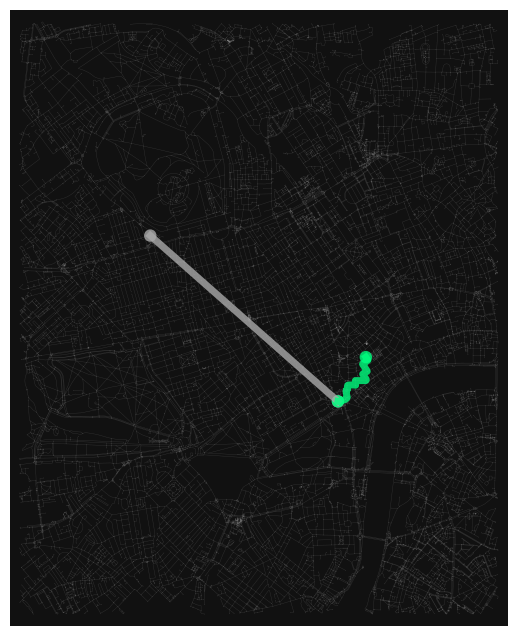

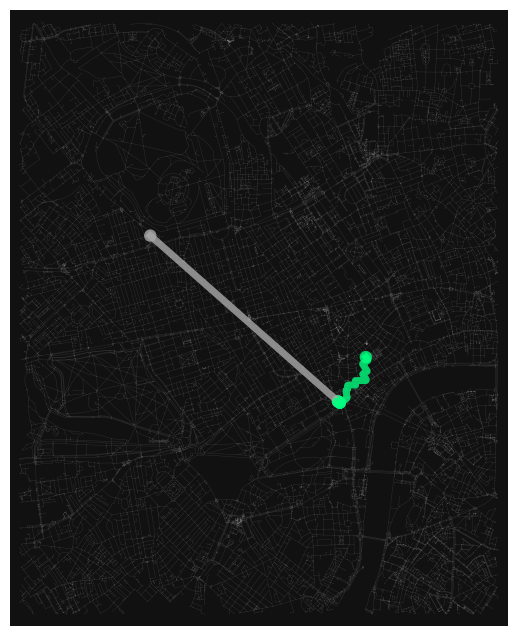

In [93]:
cnt = 0
with open(OUTPUT_FILE, 'r') as f:
   line = f.readline()
   while line:
        cnt += 1
        line = f.readline().strip()
        original_waypoints = load_json_list(line)
        if original_waypoints == []:
            break

        line = f.readline().strip()
        original_travel_modes = load_json_list(line)
        line = f.readline().strip()
        alt1_waypoints = load_json_list(line)
        line = f.readline().strip()
        alt1_travel_modes = load_json_list(line)
        line = f.readline().strip()
        alt2_waypoints = load_json_list(line)
        line = f.readline().strip()
        alt2_travel_modes = load_json_list(line)

        origin = str_geo_value(original_waypoints[0]['lng']), str_geo_value(original_waypoints[0]['lat'])
        end = str_geo_value(original_waypoints[-1]['lng']), str_geo_value(original_waypoints[-1]['lat'])

        north, south, east, west = get_bbox_bound(original_waypoints + alt1_waypoints + alt2_waypoints)
        G = ox.graph_from_bbox(north, south, east, west, network_type="walk")

        paths, path_colors = get_paths(G, original_waypoints, original_travel_modes)
       
        fig, ax = ox.plot_graph_routes(G, paths, route_linewidths=5, route_colors=path_colors, route_alpha=.8, \
                            node_color='w', node_alpha =.2, node_size=.2, orig_dest_size=80, edge_linewidth=0.3, edge_color="dimgray", edge_alpha=.2, dpi=100) 

        fig.savefig(f"output_google_paths/{origin[0]}_{origin[1]}_{end[0]}_{end[1]}_original.png", dpi=100, bbox_inches='tight')
        fig.clf()
        
        alt_waypoints = alt1_waypoints + alt2_waypoints
        alt_travel_modes = alt1_travel_modes + alt2_travel_modes
        paths, path_colors = get_paths(G, alt_waypoints, alt_travel_modes)
       
        fig, ax = ox.plot_graph_routes(G, paths, route_linewidths=5, route_colors=path_colors, route_alpha=.8, \
                            node_color='w', node_alpha =.2, node_size=.2, orig_dest_size=80, edge_linewidth=0.3, edge_color="dimgray", edge_alpha=.2, dpi=100) 

        fig.savefig(f"output_google_paths/{origin[0]}_{origin[1]}_{end[0]}_{end[1]}_alt.png", dpi=100, bbox_inches='tight')
        
        if cnt == 5:
            break